In [1]:
# Project in which I analyze Brooklyn neighborhood in NYC, (USA) by clustering and segmenting of the venues

In [ ]:
!pip install geocoder
!pip install geopy
!pip install folium

In [2]:
#Import libraries
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json  
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
import folium 

In [41]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json

In [42]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [43]:
NY_neighborhoods= newyork_data['features']

In [44]:
# Define the dataframe columns and initiate
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [45]:
#Loop and fill dataframe one column at the time
for data in NY_neighborhoods:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [46]:
# Dataframe head
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [47]:
#Shape of dataframe
neighborhoods.shape

(306, 4)

In [48]:
# Segmentation and clustering of the neighborhoods in the vicinity of Brooklyn
Brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)

In [49]:
Brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [50]:
Brooklyn_data.shape

(70, 4)

In [51]:
# Get Brooklyn's latitute and longitude
address = 'Brooklyn'
geolocator = Nominatim(user_agent="brooklyn_restaurants")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Brooklyn borough coordinates: {}, {}.'.format(latitude, longitude))

Brooklyn borough coordinates: 40.6501038, -73.9495823.


In [52]:
#Create map of Brooklyn
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=13)

#Add markers 
for lat, lng, label in zip(Brooklyn_data['Latitude'], Brooklyn_data['Longitude'], Brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='slateblue',
        fill=True,
        fill_color='#steelblue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn) 
#Visulaize the result    
map_brooklyn

In [53]:
# Foursquare
CLIENT_ID = '3F53LDALYKVG2EL5MVLTXZ2TK0MBECFBK5PM5WT5SVQSOZU1' 
CLIENT_SECRET = 'HDAUY3EAYDRBXUR3L2G05IYCYDTMYINUVM5WBNB02K2WLXPW' 
VERSION = '20210513' 
LIMIT = 100 
radius = 600

In [54]:
Brooklyn_data.loc[0, 'Neighborhood']

'Bay Ridge'

In [55]:
#Top 50 venues in Bay Ridge in a 600 meters radius
neighborhood_latitude = Brooklyn_data.loc[0, 'Latitude'] # neighborhood latitude 
neighborhood_longitude = Brooklyn_data.loc[0, 'Longitude'] # neighborhood longitude 
neighborhood_name = Brooklyn_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude of {}: {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude of Bay Ridge: 40.625801065010656, -74.03062069353813.


In [56]:
LIMIT = 50

radius = 600

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=3F53LDALYKVG2EL5MVLTXZ2TK0MBECFBK5PM5WT5SVQSOZU1&client_secret=HDAUY3EAYDRBXUR3L2G05IYCYDTMYINUVM5WBNB02K2WLXPW&v=20210513&ll=40.625801065010656,-74.03062069353813&radius=500&limit=50'

In [57]:
results = requests.get(url).json() #Get url

In [58]:
# Define the fucntion that will get the venue categories for Bay Ridge
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [59]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# Filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# Filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# Clean the columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Pilo Arts Day Spa and Salon,Spa,40.624748,-74.030591
1,Bagel Boy,Bagel Shop,40.627896,-74.029335
2,Leo's Casa Calamari,Pizza Place,40.624200,-74.030931
3,Pegasus Cafe,Breakfast Spot,40.623168,-74.031186
4,Georgian Dream Cafe and Bakery,Caucasian Restaurant,40.625586,-74.030196


In [60]:
print('{} venues were returned using Foursquare.'.format(nearby_venues.shape[0]))
print ('{} unique categories in Bay Ridge.'.format(nearby_venues['categories'].value_counts().shape[0]))
print (nearby_venues['categories'].value_counts()[0:4])

50 venues were returned using Foursquare.
35 unique categories in Bay Ridge.
Spa                   5
Greek Restaurant      3
Italian Restaurant    3
Pizza Place           3
Name: categories, dtype: int64


In [61]:
#Brooklyn's neighborhood venues exploraory analysis function
def getNearbyVenues(names, latitudes, longitudes, radius=3000, LIMIT=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # Create API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [62]:
Brooklyn_venues = getNearbyVenues(names=Brooklyn_data['Neighborhood'],
                                   latitudes=Brooklyn_data['Latitude'],
                                   longitudes=Brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [63]:
Brooklyn_venues.shape

(6994, 7)

In [64]:
Brooklyn_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
1,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
2,Bay Ridge,40.625801,-74.030621,Mimi Nails,40.622571,-74.031477,Spa
3,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place
4,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot


In [65]:
# Drop rows in which Venue Category is only for restaurant
Brooklyn_venues.drop(Brooklyn_venues.loc[Brooklyn_venues['Venue Category']=='Restaurant'].index, inplace=True)

In [66]:
Brooklyn_venues.shape

(6934, 7)

In [67]:
# Create df for restaurants 
Brooklyn_venues_restaurant = Brooklyn_venues[Brooklyn_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
Brooklyn_venues_restaurant.index = np.arange(1, len(Brooklyn_venues_restaurant )+1)

In [68]:
print (Brooklyn_venues_restaurant['Venue Category'].value_counts())

Italian Restaurant                 229
Caribbean Restaurant               210
American Restaurant                109
Mexican Restaurant                  98
Sushi Restaurant                    87
Chinese Restaurant                  69
Japanese Restaurant                 67
Thai Restaurant                     49
Latin American Restaurant           44
Seafood Restaurant                  43
Indian Restaurant                   37
New American Restaurant             36
Turkish Restaurant                  34
French Restaurant                   33
Vietnamese Restaurant               32
Middle Eastern Restaurant           32
Russian Restaurant                  31
Tapas Restaurant                    29
Mediterranean Restaurant            28
Fast Food Restaurant                27
Greek Restaurant                    25
Eastern European Restaurant         25
Southern / Soul Food Restaurant     23
Asian Restaurant                    18
Peruvian Restaurant                 15
Vegetarian / Vegan Restau

In [69]:
Brooklyn_venues_restaurant.shape

(1642, 7)

In [70]:
Brooklyn_venues_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Bay Ridge,40.625801,-74.030621,Karam,40.622931,-74.028316,Middle Eastern Restaurant
2,Bay Ridge,40.625801,-74.030621,Tanoreen,40.630726,-74.027954,Middle Eastern Restaurant
3,Bay Ridge,40.625801,-74.030621,Tuscany Grill,40.622913,-74.031387,Italian Restaurant
4,Bay Ridge,40.625801,-74.030621,Chadwick's Restaurant,40.621450,-74.031964,American Restaurant
5,Bay Ridge,40.625801,-74.030621,Gino's Restaurant,40.629859,-74.022543,Italian Restaurant


In [71]:
# create df for top 10 categories
Brooklyn_venues_restaurant_Top10 = Brooklyn_venues_restaurant['Venue Category'].value_counts()[0:10
                                                                                               ].to_frame(name='frequency')
Brooklyn_venues_restaurant_Top10=Brooklyn_venues_restaurant_Top10.reset_index()
Brooklyn_venues_restaurant_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Brooklyn_venues_restaurant_Top10

,Venue_Category,Frequency
0,Italian Restaurant,229
1,Caribbean Restaurant,210
2,American Restaurant,109
3,Mexican Restaurant,98
4,Sushi Restaurant,87
5,Chinese Restaurant,69
6,Japanese Restaurant,67
7,Thai Restaurant,49
8,Latin American Restaurant,44
9,Seafood Restaurant,43


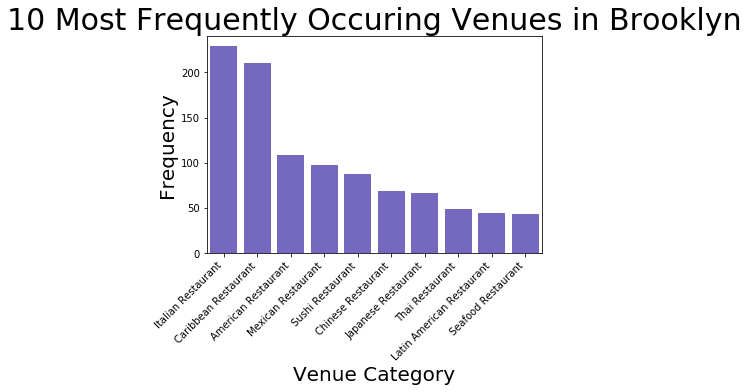

<Figure size 1800x576 with 0 Axes>

In [72]:
#Set Venue_Category as Index + visualize results

import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=Brooklyn_venues_restaurant_Top10, color='slateblue')
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Venues in Brooklyn', fontsize=30)
plt.xlabel("Venue Category", fontsize=20)
plt.ylabel ("Frequency", fontsize=20)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(25,8))
plt.show()

In [73]:
Brooklyn_venues_restaurant.shape
print('There are {} unique categories.'.format(len(Brooklyn_venues_restaurant['Venue Category'].unique())))

There are 61 unique categories.


In [74]:
#Neighborhood analysis
Brooklyn_restaurant = Brooklyn_venues_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
Brooklyn_restaurant

Neighborhood
Bath Beach                   22
Bay Ridge                    25
Bedford Stuyvesant           28
Bensonhurst                  27
Bergen Beach                 17
Boerum Hill                  24
Borough Park                 30
Brighton Beach               22
Broadway Junction            26
Brooklyn Heights             18
Brownsville                  26
Bushwick                     18
Canarsie                     23
Carroll Gardens              20
City Line                    13
Clinton Hill                 27
Cobble Hill                  19
Coney Island                  8
Crown Heights                31
Cypress Hills                14
Ditmas Park                  26
Downtown                     21
Dumbo                        17
Dyker Heights                26
East Flatbush                34
East New York                11
East Williamsburg            24
Erasmus                      28
Flatbush                     26
Flatlands                    29
Fort Greene                

In [76]:
Brooklyn_restaurant_df  = Brooklyn_restaurant.to_frame().reset_index()
Brooklyn_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
Brooklyn_restaurant_df.index = np.arange(1, len(Brooklyn_restaurant_df)+1)
list_rest_no =Brooklyn_restaurant_df['Number of Restaurant'].tolist()
list_dist =Brooklyn_restaurant_df['Neighborhood'].tolist()

In [77]:
# One hot encoding
Brooklyn_onehot = pd.get_dummies(Brooklyn_venues_restaurant[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to df
Brooklyn_onehot['Neighborhood'] = Brooklyn_venues_restaurant['Neighborhood'] 

# Switch neighborhood column to 1st column in df
fixed_columns = [Brooklyn_onehot.columns[-1]] + list(Brooklyn_onehot.columns[:-1])
Brooklyn_onehot = Brooklyn_onehot[fixed_columns]
Brooklyn_onehot.head(10)

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Russian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
1,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bay Ridge,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Bay Ridge,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
Brooklyn_onehot.shape

(1642, 62)

In [79]:
#Grouping by neighbourhoods and showing the mean of the frequency of occurrence for each category of restaurant
Brooklyn_restaurant_grouped = Brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
Brooklyn_restaurant_grouped.head(10)

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Russian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Bath Beach,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.045455,0.0,0.090909,0.000000,0.0,0.045455,0.000000,0.000000,0.000000,0.0,0.000000,0.045455,0.000000,0.000000,0.000000,0.045455,0.045455,0.0,0.000000,0.000000,0.000000,0.000000,0.363636,0.000000,0.0,0.000000,0.000000,0.000000,0.136364,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.090909,0.0,0.000000,0.000000,0.000000,0.000000,0.045455,0.0,0.000000,0.045455,0.00
1,Bay Ridge,0.000000,0.160000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.080000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.0,0.000000,0.000000,0.040000,0.000000,0.160000,0.040000,0.0,0.000000,0.000000,0.000000,0.080000,0.120000,0.0,0.0,0.040000,0.000000,0.000000,0.0,0.000000,0.000000,0.040000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.080000,0.0,0.000000,0.000000,0.04
2,Bedford Stuyvesant,0.035714,0.071429,0.0,0.0,0.035714,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.071429,0.0,0.000000,0.035714,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.142857,0.071429,0.0,0.000000,0.035714,0.000000,0.107143,0.000000,0.0,0.0,0.107143,0.000000,0.000000,0.0,0.000000,0.000000,0.035714,0.0,0.071429,0.000000,0.071429,0.0,0.000000,0.000000,0.071429,0.000000,0.000000,0.0,0.000000,0.000000,0.00
3,Bensonhurst,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.037037,0.0,0.111111,0.000000,0.0,0.111111,0.000000,0.000000,0.000000,0.0,0.000000,0.037037,0.000000,0.000000,0.000000,0.037037,0.037037,0.0,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,0.0,0.000000,0.000000,0.000000,0.074074,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.037037,0.037037,0.0,0.000000,0.000000,0.074074,0.0,0.000000,0.000000,0.000000,0.000000,0.111111,0.0,0.000000,0.074074,0.00
4,Bergen Beach,0.000000,0.117647,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.352941,0.0,0.117647,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000,0.0,0.000000,0.000000,0.000000,0.058824,0.000000,0.0,0.0,0.000000,0.000000,0.058824,0.0,0.000000,0.000000,0.058824,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00
5,Boerum Hill,0.000000,0.083333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.041667,0.000000,0.041667,0.0,0.041667,0.000000,0.000000,0.000000,0.041667,0.000000,0.041667,0.0,0.000000,0.000000,0.000000,0.041667,0.208333,0.041667,0.0,0.041667,0.083333,0.000000,0.000000,0.000000,0.

In [80]:
Brooklyn_restaurant_grouped.shape

(70, 62)

In [81]:
num_top_venues = 10

for hood in Brooklyn_restaurant_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Brooklyn_restaurant_grouped[Brooklyn_restaurant_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                   venue  freq
0     Italian Restaurant  0.36
1     Mexican Restaurant  0.14
2       Sushi Restaurant  0.09
3   Cantonese Restaurant  0.09
4     Turkish Restaurant  0.05
5     Burmese Restaurant  0.05
6     Chinese Restaurant  0.05
7  Vietnamese Restaurant  0.05
8       Greek Restaurant  0.05
9      German Restaurant  0.05


----Bay Ridge----
                       venue  freq
0         Italian Restaurant  0.16
1        American Restaurant  0.16
2  Middle Eastern Restaurant  0.12
3           Greek Restaurant  0.12
4         Chinese Restaurant  0.08
5         Turkish Restaurant  0.08
6         Mexican Restaurant  0.08
7         Seafood Restaurant  0.04
8    New American Restaurant  0.04
9        Japanese Restaurant  0.04


----Bedford Stuyvesant----
                             venue  freq
0               Italian Restaurant  0.14
1          New American Restaurant  0.11
2               Mexican Restaurant  0.11
3                  Thai Restaurant  0.07
4

                       venue  freq
0       Caribbean Restaurant  0.19
1            Thai Restaurant  0.15
2         Italian Restaurant  0.08
3  Middle Eastern Restaurant  0.08
4   Mediterranean Restaurant  0.04
5         Mexican Restaurant  0.04
6        American Restaurant  0.04
7          Indian Restaurant  0.04
8    New American Restaurant  0.04
9          French Restaurant  0.04


----Downtown----
                         venue  freq
0           Italian Restaurant  0.29
1          American Restaurant  0.14
2           Spanish Restaurant  0.05
3          Japanese Restaurant  0.05
4           Israeli Restaurant  0.05
5           Persian Restaurant  0.05
6            French Restaurant  0.05
7         Ethiopian Restaurant  0.05
8    Latin American Restaurant  0.05
9  Eastern European Restaurant  0.05


----Dumbo----
                       venue  freq
0         Italian Restaurant  0.24
1            Thai Restaurant  0.12
2        American Restaurant  0.12
3           Asian Restaurant  0.1

                       venue  freq
0         Italian Restaurant  0.14
1        American Restaurant  0.14
2         Mexican Restaurant  0.10
3            Thai Restaurant  0.10
4       Caribbean Restaurant  0.07
5  Middle Eastern Restaurant  0.07
6          Hotpot Restaurant  0.03
7    New American Restaurant  0.03
8          French Restaurant  0.03
9        Dumpling Restaurant  0.03


----Madison----
                         venue  freq
0             Sushi Restaurant  0.21
1           Italian Restaurant  0.18
2           Russian Restaurant  0.11
3     Mediterranean Restaurant  0.11
4          Japanese Restaurant  0.07
5  Eastern European Restaurant  0.04
6    Middle Eastern Restaurant  0.04
7           Turkish Restaurant  0.04
8           Chinese Restaurant  0.04
9         Caribbean Restaurant  0.04


----Manhattan Beach----
                         venue  freq
0             Sushi Restaurant  0.18
1           Russian Restaurant  0.14
2           Italian Restaurant  0.11
3           Turk

                             venue  freq
0               Italian Restaurant  0.29
1               Mexican Restaurant  0.29
2            Vietnamese Restaurant  0.14
3                German Restaurant  0.14
4             Caribbean Restaurant  0.14
5               Russian Restaurant  0.00
6        Latin American Restaurant  0.00
7         Mediterranean Restaurant  0.00
8        Middle Eastern Restaurant  0.00
9  Molecular Gastronomy Restaurant  0.00


----Sheepshead Bay----
                         venue  freq
0             Sushi Restaurant  0.20
1           Italian Restaurant  0.13
2           Turkish Restaurant  0.13
3           Russian Restaurant  0.13
4          Japanese Restaurant  0.10
5           Seafood Restaurant  0.07
6  Eastern European Restaurant  0.07
7        Vietnamese Restaurant  0.03
8     Mediterranean Restaurant  0.03
9           Mexican Restaurant  0.03


----South Side----
                       venue  freq
0         Italian Restaurant  0.12
1         Chinese Restaura

In [82]:
#Create pandas df
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [83]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new df
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Brooklyn_restaurant_grouped['Neighborhood']

for ind in np.arange(Brooklyn_restaurant_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Brooklyn_restaurant_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Italian Restaurant,Mexican Restaurant,Sushi Restaurant,Cantonese Restaurant,Vietnamese Restaurant,Greek Restaurant,German Restaurant,Falafel Restaurant,Burmese Restaurant,Chinese Restaurant
1,Bay Ridge,Italian Restaurant,American Restaurant,Greek Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Turkish Restaurant,Mexican Restaurant,Seafood Restaurant,Indian Restaurant,Japanese Restaurant
2,Bedford Stuyvesant,Italian Restaurant,Mexican Restaurant,New American Restaurant,American Restaurant,Caribbean Restaurant,Thai Restaurant,Japanese Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant
3,Bensonhurst,Italian Restaurant,Chinese Restaurant,Cantonese Restaurant,Turkish Restaurant,Mexican Restaurant,Sushi Restaurant,Vietnamese Restaurant,Falafel Restaurant,Burmese Restaurant,German Restaurant
4,Bergen Beach,Caribbean Restaurant,Italian Restaurant,American Restaurant,Chinese Restaurant,Fast Food Restaurant,Peruvian Restaurant,Seafood Restaurant,Mexican Restaurant,Filipino Restaurant,French Restaurant
5,Boerum Hill,Italian Restaurant,American Restaurant,Latin American Restaurant,Eastern European Restaurant,Persian Restaurant,Greek Restaurant,Ethiopian Restaurant,Ramen Restaurant,Seafood Restaurant,Korean Restaurant
6,Borough Park,Mexican Restaurant,Italian Restaurant,Thai Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Hotpot Restaurant,Taiwanese Restaurant,Vegetarian / Vegan Restaurant
7,Brighton Beach,Italian Restaurant,Russian Restaurant,Mexican Restaurant,Sushi Restaurant,Eastern European Restaurant,Turkish Restaurant,Vietnamese Restaurant,Asian Restaurant,Japanese Restaurant,Mediterranean Restaurant
8,Broadway Junction,Caribbean Restaurant,Latin American Restaurant,Mexican Restaurant,American Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,Southern / Soul Food Restaurant,Chinese Restaurant,Fast Food Restaurant
9,Brooklyn Heights,Italian Restaurant,American Restaurant,New American Restaurant,Eastern European Restaurant,Seafood Restaurant,Spanish Restaurant,Latin American Restaurant,Cuban Restaurant,Tapas Restaurant,Vietnamese Restaurant


In [84]:
#Niehgborhood Clustering w KmEANS
#Set number of clusters 
kclusters = 5

Brooklyn_restaurant_grouped_clustering = Brooklyn_restaurant_grouped.drop('Neighborhood', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Brooklyn_restaurant_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 4, 0, 1, 4, 4, 0, 3, 4])

In [85]:
# Add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Brooklyn_merged = Brooklyn_data

# Merge to add longitude + latitute for each neighborhood
Brooklyn_merged = Brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Brooklyn_merged.head() # check the last columns

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,4,Italian Restaurant,American Restaurant,Greek Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Turkish Restaurant,Mexican Restaurant,Seafood Restaurant,Indian Restaurant,Japanese Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,0,Italian Restaurant,Chinese Restaurant,Cantonese Restaurant,Turkish Restaurant,Mexican Restaurant,Sushi Restaurant,Vietnamese Restaurant,Falafel Restaurant,Burmese Restaurant,German Restaurant
2,Brooklyn,Sunset Park,40.645103,-74.010316,4,Italian Restaurant,American Restaurant,Mexican Restaurant,Greek Restaurant,Vietnamese Restaurant,Chinese Restaurant,Cantonese Restaurant,Seafood Restaurant,Dumpling Restaurant,Kebab Restaurant
3,Brooklyn,Greenpoint,40.730201,-73.954241,4,Japanese Restaurant,Italian Restaurant,French Restaurant,Mexican Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Peruvian Restaurant
4,Brooklyn,Gravesend,40.595260,-73.973471,0,Sushi Restaurant,Italian Restaurant,Russian Restaurant,Mexican Restaurant,Eastern European Restaurant,Turkish Restaurant,Asian Restaurant,Burmese Restaurant,Mediterranean Restaurant,Vietnamese Restaurant


In [86]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# Set color for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to map
markers_colors = []
for lat, lon, poi, cluster in zip(Brooklyn_merged['Latitude'], Brooklyn_merged['Longitude'], Brooklyn_merged['Neighborhood'], Brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [87]:
#Cluster 1
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 0, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bensonhurst,Italian Restaurant,Chinese Restaurant,Cantonese Restaurant,Turkish Restaurant,Mexican Restaurant,Sushi Restaurant,Vietnamese Restaurant,Falafel Restaurant,Burmese Restaurant,German Restaurant
4,Gravesend,Sushi Restaurant,Italian Restaurant,Russian Restaurant,Mexican Restaurant,Eastern European Restaurant,Turkish Restaurant,Asian Restaurant,Burmese Restaurant,Mediterranean Restaurant,Vietnamese Restaurant
5,Brighton Beach,Italian Restaurant,Russian Restaurant,Mexican Restaurant,Sushi Restaurant,Eastern European Restaurant,Turkish Restaurant,Vietnamese Restaurant,Asian Restaurant,Japanese Restaurant,Mediterranean Restaurant
6,Sheepshead Bay,Sushi Restaurant,Turkish Restaurant,Russian Restaurant,Italian Restaurant,Japanese Restaurant,Seafood Restaurant,Eastern European Restaurant,Vietnamese Restaurant,Asian Restaurant,Mediterranean Restaurant
7,Manhattan Terrace,Italian Restaurant,Sushi Restaurant,Caribbean Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant,Japanese Restaurant,Russian Restaurant,Turkish Restaurant
31,Manhattan Beach,Sushi Restaurant,Russian Restaurant,Turkish Restaurant,Japanese Restaurant,Italian Restaurant,Eastern European Restaurant,Seafood Restaurant,Asian Restaurant,Vietnamese Restaurant,Mediterranean Restaurant
32,Coney Island,Italian Restaurant,Mexican Restaurant,Asian Restaurant,Eastern European Restaurant,Caribbean Restaurant,Russian Restaurant,Australian Restaurant,Empanada Restaurant,Himalayan Restaurant,Halal Restaurant
33,Bath Beach,Italian Restaurant,Mexican Restaurant,Sushi Restaurant,Cantonese Restaurant,Vietnamese Restaurant,Greek Restaurant,German Restaurant,Falafel Restaurant,Burmese Restaurant,Chinese Restaurant
36,Gerritsen Beach,Sushi Restaurant,Italian Restaurant,Turkish Restaurant,Japanese Restaurant,Seafood Restaurant,Eastern European Restaurant,Russian Restaurant,Vietnamese Restaurant,Mediterranean Restaurant,Mexican Restaurant
37,Marine Park,Italian Restaurant,American Restaurant,Sushi Restaurant,Japanese Restaurant,Mexican Restaurant,Caribbean Restaurant,Russian Restaurant,Seafood Restaurant,Chinese Restaurant,Peruvian Restaurant


In [88]:
#Cluster 2
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 1, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,East Flatbush,Caribbean Restaurant,Indian Restaurant,Chinese Restaurant,Austrian Restaurant,Fast Food Restaurant,Empanada Restaurant,New American Restaurant,Italian Restaurant,American Restaurant,Tapas Restaurant
14,Brownsville,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,French Restaurant,Indian Restaurant,African Restaurant,Tapas Restaurant,Israeli Restaurant,Japanese Restaurant,Southern / Soul Food Restaurant
27,Starrett City,Caribbean Restaurant,Fast Food Restaurant,Italian Restaurant,American Restaurant,Dumpling Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
28,Canarsie,Caribbean Restaurant,Fast Food Restaurant,Italian Restaurant,American Restaurant,Peruvian Restaurant,Indian Restaurant,Chinese Restaurant,Mexican Restaurant,Japanese Restaurant,French Restaurant
29,Flatlands,Caribbean Restaurant,Italian Restaurant,American Restaurant,Chinese Restaurant,Indian Restaurant,Peruvian Restaurant,Fast Food Restaurant,Mexican Restaurant,Japanese Restaurant,French Restaurant
45,Bergen Beach,Caribbean Restaurant,Italian Restaurant,American Restaurant,Chinese Restaurant,Fast Food Restaurant,Peruvian Restaurant,Seafood Restaurant,Mexican Restaurant,Filipino Restaurant,French Restaurant
48,Georgetown,Caribbean Restaurant,Italian Restaurant,American Restaurant,Chinese Restaurant,Japanese Restaurant,Mexican Restaurant,Fast Food Restaurant,Peruvian Restaurant,Seafood Restaurant,Indian Restaurant
56,Rugby,Caribbean Restaurant,Chinese Restaurant,Indian Restaurant,Thai Restaurant,Fast Food Restaurant,Ramen Restaurant,Empanada Restaurant,Southern / Soul Food Restaurant,Italian Restaurant,Tapas Restaurant
57,Remsen Village,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Spanish Restaurant,Indian Restaurant,Mexican Restaurant,Japanese Restaurant,American Restaurant,German Restaurant
59,Paerdegat Basin,Caribbean Restaurant,Italian Restaurant,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Peruvian Restaurant,Japanese Restaurant,Chinese Restaurant,Indian Restaurant,Halal Restaurant


In [89]:
#Cluster 3
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 2, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,East New York,Latin American Restaurant,Caribbean Restaurant,Fast Food Restaurant,South American Restaurant,Japanese Restaurant,Yemeni Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,French Restaurant
58,New Lots,Caribbean Restaurant,Fast Food Restaurant,Latin American Restaurant,American Restaurant,Japanese Restaurant,South American Restaurant,Yemeni Restaurant,Filipino Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [90]:
#Cluster 4
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 3, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Flatbush,Caribbean Restaurant,Thai Restaurant,Italian Restaurant,Middle Eastern Restaurant,Sushi Restaurant,New American Restaurant,Mediterranean Restaurant,Korean Restaurant,Empanada Restaurant,Austrian Restaurant
9,Crown Heights,Caribbean Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Italian Restaurant,American Restaurant,Mexican Restaurant,New American Restaurant,African Restaurant,Thai Restaurant,French Restaurant
42,Prospect Lefferts Gardens,Caribbean Restaurant,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Indian Restaurant,Mexican Restaurant,American Restaurant,Austrian Restaurant,Cajun / Creole Restaurant,Chinese Restaurant
43,Ocean Hill,Caribbean Restaurant,Italian Restaurant,Mexican Restaurant,French Restaurant,Indian Restaurant,Seafood Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Israeli Restaurant
46,Midwood,Caribbean Restaurant,Italian Restaurant,Mexican Restaurant,Thai Restaurant,Mediterranean Restaurant,Indian Restaurant,Chinese Restaurant,Russian Restaurant,Burmese Restaurant,Austrian Restaurant
47,Prospect Park South,Caribbean Restaurant,Thai Restaurant,Italian Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,New American Restaurant,Chinese Restaurant,Korean Restaurant,Empanada Restaurant,Austrian Restaurant
54,Ditmas Park,Caribbean Restaurant,Thai Restaurant,Italian Restaurant,Middle Eastern Restaurant,Sushi Restaurant,New American Restaurant,Mediterranean Restaurant,Korean Restaurant,Empanada Restaurant,Austrian Restaurant
55,Wingate,Caribbean Restaurant,Sushi Restaurant,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Tapas Restaurant,Indian Restaurant,Mexican Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant
63,Weeksville,Caribbean Restaurant,African Restaurant,French Restaurant,Southern / Soul Food Restaurant,American Restaurant,Tapas Restaurant,Sushi Restaurant,Mexican Restaurant,New American Restaurant,Seafood Restaurant
64,Broadway Junction,Caribbean Restaurant,Latin American Restaurant,Mexican Restaurant,American Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,Southern / Soul Food Restaurant,Chinese Restaurant,Fast Food Restaurant


In [91]:
#Cluster 5
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 4, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Italian Restaurant,American Restaurant,Greek Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Turkish Restaurant,Mexican Restaurant,Seafood Restaurant,Indian Restaurant,Japanese Restaurant
2,Sunset Park,Italian Restaurant,American Restaurant,Mexican Restaurant,Greek Restaurant,Vietnamese Restaurant,Chinese Restaurant,Cantonese Restaurant,Seafood Restaurant,Dumpling Restaurant,Kebab Restaurant
3,Greenpoint,Japanese Restaurant,Italian Restaurant,French Restaurant,Mexican Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Peruvian Restaurant
11,Kensington,Italian Restaurant,American Restaurant,Mexican Restaurant,Thai Restaurant,Caribbean Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,New American Restaurant,Chinese Restaurant,Mediterranean Restaurant
12,Windsor Terrace,Italian Restaurant,Mexican Restaurant,American Restaurant,Caribbean Restaurant,Thai Restaurant,Korean Restaurant,Chinese Restaurant,French Restaurant,Sushi Restaurant,Austrian Restaurant
13,Prospect Heights,Italian Restaurant,Latin American Restaurant,Sushi Restaurant,New American Restaurant,Ramen Restaurant,Mexican Restaurant,American Restaurant,Israeli Restaurant,Tapas Restaurant,Vietnamese Restaurant
15,Williamsburg,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Latin American Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,South American Restaurant
16,Bushwick,Italian Restaurant,Mexican Restaurant,Seafood Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Ethiopian Restaurant,French Restaurant
17,Bedford Stuyvesant,Italian Restaurant,Mexican Restaurant,New American Restaurant,American Restaurant,Caribbean Restaurant,Thai Restaurant,Japanese Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant
18,Brooklyn Heights,Italian Restaurant,American Restaurant,New American Restaurant,Eastern European Restaurant,Seafood Restaurant,Spanish Restaurant,Latin American Restaurant,Cuban Restaurant,Tapas Restaurant,Vietnamese Restaurant
